# The vtreat Score Frame

Nina Zumel and John Mount
March 2020

Note: this is a description of the [`Python` version of `vtreat`](https://github.com/WinVector/pyvtreat), the same example for the [`R` version of `vtreat`](https://github.com/WinVector/vtreat) can be found [here](https://github.com/WinVector/vtreat/blob/master/Examples/Regression/Regression.md).

This note describes the entries of the `vtreat` score frame. Let's set up a regression example to see the score frame.

## Preliminaries

Load modules/packages.

In [1]:
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot as plt
import matplotlib.pyplot
import vtreat
import vtreat.util
import wvpy.util

numpy.random.seed(2019)

Generate example data. 

* `y` is a noisy sinusoidal plus linear function of the variable `x`, and is the output to be predicted
* Input `xc` is a categorical variable that represents a discretization of `y`, along with some `NaN`s
* Input `x2` is a pure noise variable with no relationship to the output

In [2]:
def make_data(nrows):
    d = pandas.DataFrame({'x': 5*numpy.random.normal(size=nrows)})
    d['y'] = numpy.sin(d['x']) + 0.01*d['x'] + 0.1*numpy.random.normal(size=nrows)
    d.loc[numpy.arange(3, 10), 'x'] = numpy.nan                           # introduce a nan level
    d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
    d['x2'] = numpy.random.normal(size=nrows)
    d.loc[d['xc']=='level_-1.0', 'xc'] = numpy.nan  # introduce a nan level
    return d

d = make_data(500)

d.head()

,x,y,xc,x2
0,-1.088395,-0.967195,NaN,-1.424184
1,4.107277,-0.630491,level_-0.5,0.427360
2,7.406389,0.980367,level_1.0,0.668849
3,NaN,0.289385,level_0.5,-0.015787
4,NaN,-0.993524,NaN,-0.491017


### Some quick data exploration

Check how many levels `xc` has, and their distribution (including `NaN`)

In [3]:
d['xc'].unique()

array([nan, 'level_-0.5', 'level_1.0', 'level_0.5', 'level_-0.0',
       'level_0.0', 'level_1.5'], dtype=object)

In [4]:
d['xc'].value_counts(dropna=False)

level_1.0     133
NaN           105
level_-0.5    104
level_0.5      80
level_-0.0     40
level_0.0      36
level_1.5       2
Name: xc, dtype: int64

Find the mean value of `y`

In [5]:
numpy.mean(d['y'])

0.03137290675104681

Plot of `y` versus `x`.

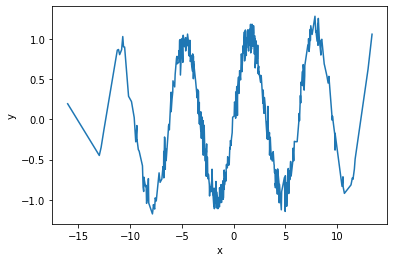

In [6]:
seaborn.lineplot(x='x', y='y', data=d)

## Build a transform appropriate for regression problems.

Now that we have the data, we want to treat it prior to modeling: we want training data where all the input variables are numeric and have no missing values or `NaN`s.

First create the data treatment transform object, in this case a treatment for a regression problem.

In [7]:
transform = vtreat.NumericOutcomeTreatment(
    outcome_name='y',    # outcome variable
)  

Notice that for the training data `d`: `transform_design$crossFrame` is **not** the same as `transform.prepare(d)`; the second call can lead to nested model bias in some situations, and is **not** recommended.
For other, later data, not seen during transform design `transform.preprare(o)` is an appropriate step.

Use the training data `d` to fit the transform and the return a treated training set: completely numeric, with no missing values.

In [8]:
d_prepared = transform.fit_transform(d, d['y'])

Now examine the score frame, which gives information about each new variable, including its type, which original variable it is  derived from, its (cross-validated) correlation with the outcome, and its (cross-validated) significance as a one-variable linear model for the outcome. 

In [9]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,R2,significance,vcount,default_threshold,recommended
0,x_is_bad,x,missing_indicator,False,True,-0.042128,0.001775,3.471792e-01,2.0,0.083333,False
1,xc_is_bad,xc,missing_indicator,False,True,-0.668393,0.446749,5.183376e-66,2.0,0.083333,True
2,x,x,clean_copy,False,True,0.098345,0.009672,2.788603e-02,2.0,0.083333,True
3,x2,x2,clean_copy,False,True,0.097028,0.009414,3.005973e-02,2.0,0.083333,True
4,xc_impact_code,xc,impact_code,True,True,0.980039,0.960476,0.000000e+00,1.0,0.166667,True
5,xc_deviation_code,xc,deviation_code,True,True,0.037635,0.001416,4.010596e-01,1.0,0.166667,False
6,xc_prevalence_code,xc,prevalence_code,False,True,0.217891,0.047476,8.689113e-07,1.0,0.166667,True
7,xc_lev_level_1_0,xc,indicator_code,False,True,0.750882,0.563824,8.969185e-92,4.0,0.041667,True
8,xc_lev__NA_,xc,indicator_code,False,True,-0.668393,0.446749,5.183376e-66,4.0,0.041667,True
9,xc_lev_level_-0_5,xc,indicator_code,False,True,-0.392501,0.154057,7.287692e-20,4.0,0.041667,True


Note that the variable `xc` has been converted to multiple variables: 

* an indicator variable for each common possible level (`xc_lev_level_*`)
* the value of a (cross-validated) one-variable model for `y` as a function of `xc` (`xc_impact_code`)
* a variable indicating when `xc` was `NaN` in the original data (`xc_is_bad`)
* a variable that returns how prevalent this particular value of `xc` is in the training data (`xc_prevalence_code`)
* a variable that returns standard deviation of `y` conditioned on `xc` (`xc_deviation_code`)

Any or all of these new variables are available for downstream modeling.

## The Score Frame Columns

The score frame columns are:

  * `variable`
> The name of the new explanatory (model input) variable being produced.  For most treatments this is the row-key for the score frame table.  For multinomial treatments the row key is `variable` plus an additional column called `outcome_target` which shows with respect to which outcome target the scoring columns were calculated. 
  * `orig_variable`
> The name of the original explanatory (model input) variable `vtreat` is working with to produce the new explanatory variable. This comes from the column names of the data frame used to design the treatment. `vtreat` is designed for `pandas.DataFrame`, which emphasizes column names. When using `numpy` matrices a string form of the column index is use as the variable name.  A single input variable can result in more than one new variable.
  * `treatment`
> The name of the process used to convert the original variable into a new column.  An example value is: `clean_copy` which is just a numeric variable copied forward with missing values imputed-out.  Other important include: `missing_indicator` (indicates which rows had missing values for a given variable), `impact_code` (the y-aware re-encoding of a categorical variable as a single number), `indicator_code` (codes individual levels of a categorical variable, only non-rare levels are so encoded), `prevalence_code` how rare or common a given level is, `deviation_code` the conditional standard deviation of the outcome.
  * `y_aware`
> In indicator showing knowledge of the dependent variable (the outcome or "y") was used in building the variable treatment.  This means that non-cross-validated estimates of the variables relation to the dependent variable would be over-fit and unreliable. All statistics in the score frame are in fact computed in a cross-validated manner, so this is just an extra warning.
  * `has_range`
> An indicator showing that the variable varies in both the input training frame and in the cross validated processed training frame (the "cross-frame").  Variables that don't move in both places are not useful for modeling.
  * `PearsonR`
> The estimated out of sample correlation between the variable and the outcome (the "y" or dependent variable).  This is an estimate of out of sample performance produced by cross-validation.
  * `R2`
> The estimated out of sample R-squared relation between the variable and the outcome (the "y" or dependent variable).  For classification a [pseudo R-squared](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/) is used.  This is an estimate of out of sample performance produced by cross-validation.
  * `significance`
> The estimated significance of the `R2`.  As with all significances this is a point estimate of a random variable that we expect this to be concentrated near zero if the variable is in fact related to the outcome, and uniformly distributed in the interval `[0, 1]` if the variable is independent of the outcome.  Prior to version `0.4.0` the reported significance was of the `PearsonR` column, as there was not an `R2` column.
  * `vcount`
> This is a redundant advisory value making explicit how the `default_threshold` is calculated. `vcount` is the number of rows in the score frame that have the given value for `treatment`.
  * `default_threshold`
> This is a recommended threshold for variable pruning, discussed in detail in the next section.  The application is: the `default_threshold` is a family of non-negative number that sum to no more than 1.  So if used as a threshold, then in expectation no more than a constant number of pure noise (uncorrelated wit the outcome) variables will be selected for modeling.  Previously we used `1/score_frame.shape[0]` is the recommendation.  Now we use a more detailed scaling, described in the next section, where the level is set to `1/(len(set(score_frame$treatment)) * vcount)`.
  * `recommended`
> The `recommended` column indicates which variables are non constant (`has_range` == True) and have a significance value no larger than `default_threshold`. See the section *Deriving the Default Thresholds* below for the reasoning behind the default thresholds. Recommended columns are intended as advice about which variables appear to be most likely to be useful in a downstream model. This advice attempts to be conservative, to reduce the possibility of mistakenly 
 eliminating variables that may in fact be useful (although, obviously, it can still mistakenly eliminate variables that have a real but non-linear relationship  to the output).

## Deriving the Default Thresholds

While machine learning algorithms are generally tolerant to a reasonable number of irrelevant or noise variables, too many irrelevant variables can lead to serious overfit; see [this article](http://www.win-vector.com/blog/2014/02/bad-bayes-an-example-of-why-you-need-hold-out-testing/) for an extreme example, one we call "Bad Bayes". The default threshold is an attempt to eliminate obviously irrelevant variables early.

Imagine that you have a pure noise dataset, where none of the *n* inputs are related to the output. If you treat each variable as a one-variable model for the output, and look at the significances of each model, these significance-values will be uniformly distributed in the range [0:1]. You want to pick a weakest possible significance threshold that eliminates as many noise variables as possible. A moment's thought should convince you that a threshold of *1/n* allows only one variable through, in expectation. 

This leads to the general-case heuristic that a significance threshold of *1/n* on your variables should allow only one irrelevant variable through, in expectation (along with all the relevant variables). Hence, *1/n* used to be our recommended threshold, when we developed the R version of `vtreat`.

We noticed, however, that this biases the filtering against numerical variables, since there are at most two derived variables (of types *clean_copy* and *missing_indicator* for every numerical variable in the original data. Categorical variables, on the other hand, are expanded to many derived variables: several indicators (one for every common level), plus a *logit_code* and a *prevalence_code*. So we now reweight the thresholds. 

Suppose you have a (treated) data set with *ntreat* different types of `vtreat` variables (`clean_copy`, `indicator_code`, etc).
There are *nT* variables of type *T*. Then the default threshold for all the variables of type *T* is *1/(ntreat nT)*. This reweighting  helps to reduce the bias against any particular type of variable. The heuristic is still that the set of recommended variables will allow at most one noise variable into the set of candidate variables.

As noted above, because `vtreat` estimates variable significances using linear methods by default, some variables with a non-linear relationship  to the output may fail to pass the threshold. Setting the `filter_to_recommended` parameter to False will keep all derived variables in the treated frame, for the data scientist to filter (or not) as they will.


## Conclusion

In all cases (classification, regression, unsupervised, and multinomial classification) the intent is that `vtreat` transforms are essentially one liners.

The preparation commands are organized as follows:

 * **Regression**: [`R` regression example](https://github.com/WinVector/vtreat/blob/master/Examples/Regression/Regression.md), [`Python` regression example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.md).
 * **Classification**: [`R` classification example](https://github.com/WinVector/vtreat/blob/master/Examples/Classification/Classification.md), [`Python` classification  example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Classification/Classification.md).
 * **Unsupervised tasks**: [`R` unsupervised example](https://github.com/WinVector/vtreat/blob/master/Examples/Unsupervised/Unsupervised.md), [`Python` unsupervised example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Unsupervised/Unsupervised.md).
 * **Multinomial classification**: [`R` multinomial classification example](https://github.com/WinVector/vtreat/blob/master/Examples/Multinomial/MultinomialExample.md), [`Python` multinomial classification example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Multinomial/MultinomialExample.md).
 
The shared structure of the `score_frame` is discussed here:

  * **Score Frame** [score_frame_](https://github.com/WinVector/pyvtreat/blob/master/Examples/ScoreFrame/ScoreFrame.md).

These current revisions of the examples are designed to be small, yet complete.  So as a set they have some overlap, but the user can rely mostly on a single example for a single task type.